# Proyecto 2, Modelos de Gestión Financiera
## Sebastian Puerto
## 25 de septiembre de 2019

# Punto 2

In [50]:
from simulador_S import grafico_valor_activo

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [203]:
def d1(S, t, E, r, sig, T):
    res = np.log(E/S) - (r + sig**2/2)*(T-t)
    res = res/( sig * np.sqrt(T-t) )
    
    return res

def d2(S, t, E, r, sig, T):
    res = np.log(E/S) + (r - sig**2/2)*(T-t)
    res = res/( sig * np.sqrt(T-t) )
    
    return res

def callV(S, t, E1, E2, r, sig, T):
    
    d1E1 = d1(S, T, E1, r, sig, T)
    d1E2 = d1(S, T, E2, r, sig, T)
    d2E1 = d2(S, T, E1, r, sig, T)
    d2E2 = d2(S, T, E2, r, sig, T)
    
    p1 = norm.cdf(d1E2) - norm.cdf(d1E1)
    
    p2 = norm.cdf(d2E2)- norm.cdf(d2E1)
    return S * p1  -  E1*np.exp(-r*(T-t)) * p2

# Calculo de Rentabilidades de Portafolios

In [97]:
def portafolio_de(x, y, z):
    return  np.asarray([[x], [y], [z]])

def varPort(x, S): 
        return x.T.dot(S).dot(x)[0,0]

## Calculo de Portafolios Optimos

In [98]:
# Dada la lista de precios historicos de M activos para N+1 periodos en términos de una matriz de MxN,
# calcula el portafolio óptimo (menor varianza) (matriz Mx1 con porcentaje de inversión en cada activo)

def calcularPortOpt(precios, tau):
    M, N = np.shape(precios)
    N -= 1

    # Cálculo de matriz de retornos (MxN)
    retornos = np.zeros((M, N))
    for k in range(M):
        for i in range(N):
            retornos[k, i] = np.log(precios[k, i+1]/precios[k, i])#(precios[k, i+1]-precios[k, i])/precios[k, i] #np.log(precios[k, i+1]/precios[k, i])

    # Cálculo de vector de promedio temporal de retornos de cada activo (Mx1) 
    retProm = np.mean(retornos, 1, keepdims = True) 

    # Cálculo de matriz de covarianzas
    S = np.zeros((M,M)) # Inicializacion en 0's

    for k in range(M): # Iterar con k sobre activos
        for l in range(M): # Iterar con l sobre activos
            for i in range(N): # Iterar sobre el tiempo con i
                # Para la combinacion de activos k y l se suma la contribución a la covarianza por el tiempo i
                S[k, l] += (retornos[k, i] - retProm[k])*(retornos[l, i] - retProm[l])

    S = S/N
    #print("Matriz de covarianzas:\n", S)
    
    # Cálculo de vector de varianzas y desviaciones estándar (matrices Mx1)
    varianzas = np.array([S[i, i] for i in range(M)]).reshape((M, 1))
    desvs = np.sqrt(varianzas)
    #print("\nVarianzas:\n", varianzas)

    # Cálculo de Parametros de la teoria
    Sinv = np.linalg.inv(S)
    u = np.ones((M, 1))

    A = u.T.dot(Sinv.dot(u))[0,0]
    B = u.T.dot(Sinv.dot(retProm))[0,0]
    C = retProm.T.dot(Sinv.dot(retProm))[0,0]
    D = A*C - B**2
    
    # Cálculo de rendimientro promedio mu consistente con la taza libre de riesgo tau
    def muTau(tau):
        return (C - tau*B)/(B - tau*A)
    
    muopt = muTau(tau)#B/A
    
    # Cálculo del portafolio optimo dado parametro mu. Devuelve vector Mx1
    def xOptMu(mu): 
        return ((C - B*mu)/D) * Sinv.dot(u) + ((A*mu - B)/D) * Sinv.dot(retProm)
    
    xopt = xOptMu(muopt)
    
    # Cálculo de varianza de un portafolio x: x^T S x
    
    varopt = varPort(xopt, S) #1/A

    return xopt, varopt, S


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Mejor port de 3 (S, C):
 [[ 2.0016684]
 [-1.0016684]]
Sigma calculada para el portafolio S, opcion: 1.24253588797533e-07
Sigma calculada para el portafolio S: 0.004854653495773338
Sigma calculada para el portafolio C: 0.009682311898524011
Corr calculada para el S y C: 0.0068537123487333014


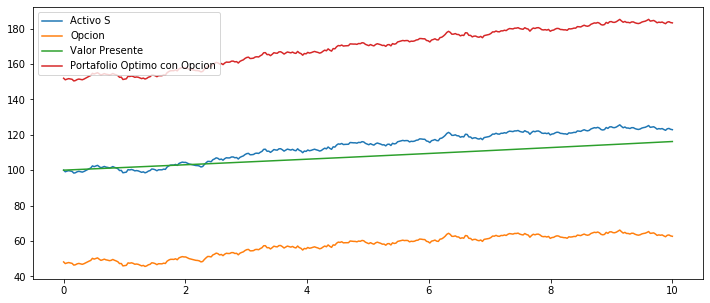

In [226]:
mmu = .02
ssig = 0.03
tau = ssig/2.

## Simulacion 1
ts, Ss = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 10, txtad = "Sim. 1", graficar = False, pts = 360)
#ts, S2s = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 60, txtad = "Sim. 2", graficar = False)

Cs = callV(S = Ss, t = ts, E1 = 70, E2 = 600000, r = tau, sig = ssig, T = 20) # r = mu / 1.2
Ls = 100.*np.exp(tau*ts)

precios = np.array([Ss, Cs])
portMej3, sig3, S = calcularPortOpt(precios, tau)
print("Mejor port de 3 (S, C):\n", portMej3)
musMej3 = portMej3[0,0]*Ss + portMej3[1,0]*Cs #+ portMej3[2,0]*Ls

#precios = np.array([Ss, Ss])
#portMej2, sig2 = calcularPortOpt(precios, tau)
#print("Mejor port de 2 (S):\n", portMej2)
#musMej2 = portMej2[0,0]*Ss + portMej2[1,0]*Ss #+ portMej2[1,0]*Ls



fig = plt.figure(figsize=(12, 5))
plt.plot(ts, Ss)
plt.plot(ts, Cs)
plt.plot(ts, Ls)
plt.plot(ts, musMej3)
#plt.plot(ts, musMej2)

plt.legend(("Activo S", "Opcion", "Valor Presente", 
            "Portafolio Optimo con Opcion", "Portafolio Optimo sin Opcion"), loc = "upper left")

#print("Sigma calculada para el portafolio S y tasa libre de riesgo:", sig2)
print("Sigma calculada para el portafolio S, opcion:", sig3)
print("Sigma calculada para el portafolio S:", np.sqrt(S[0,0]))
print("Sigma calculada para el portafolio C:", np.sqrt(S[1,1]))
print("Corr calculada para el S y C:", np.sqrt(S[0,1]))

In [227]:
def deri_C_S(Ss, Cs):
    dSs = Ss[1:] - Ss[:-1]
    dCs = Cs[1:] - Cs[:-1]
    return dSs/dCs

print(np.mean(deri_C_S(Ss, Cs)))
print(np.std(deri_C_S(Ss, Cs)))

1.1844568382820198
3.5648719285206543


In [37]:
mus  = np.array([0.001, 0.005, 0.015, 0.03])
#mus = [0.02]
sigs = [0.01, 0.05, 0.09, 0.15]
#sigs = [0.1]

ultimosS = np.array([])
ultimosMus = np.array([])
ratios = np.array([])
#rendsMej2 = []
#coeficiente = []

for i in range(100):
    for mmu in mus:
        for ssig in sigs:
            ts, Ss = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 60, txtad = "Sim. 1", graficar = False, pts = 60)

            Cs = callV(S = Ss, t = ts, E1 = 70, E2 = 600, r = tau, sig = ssig, T = 60) # r = mu / 2
            Ls = 100.*np.exp(mmu*ts/2)

            precios = np.array([Ss, Cs, Ls])
            portMej3, sig3 = calcularPortOpt(precios)
            musMej3 = portMej3[0,0]*Ss + portMej3[1,0]*Cs + portMej3[2,0]*Ls
            
            ultimosMus = np.append(ultimosMus, musMej3[-1])
            ultimosS = np.append(ultimosS, Ss[-1])
            ratios = np.append(ratios, ultimosMus[-1]/ultimosS[-1])
    
        
#rendsMej3 = np.array(rendsMej3)
#ultimosS = np.array(ultimosS)

#ratio = rendsMej3/ultimosS

mayores = 0
totales = 0
for r in ratios:
    if r > 1:
        mayores += 1
        totales += 1
    if r < 1:
        totales += 1
print(mayores, totales)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract


181 928


# Probando la Funcion Call

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


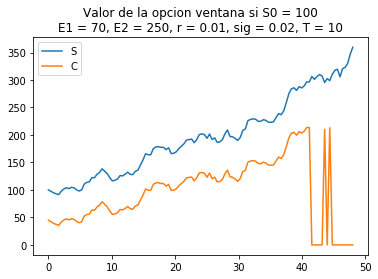

In [89]:
#callV(S = 100, t = 20, E1 = 80, E2 = 200, r = 0.015, sig = 0.09, T = 100)
#ts = np.linspace(0, 7, 100)
#Ss = np.linspace(100, 300, 100)
#cs = callV(S = Ss, t = ts, E1 = 70, E2 = 250, r = 0.01, sig = 0.02, T = 10) # Funciona chevere

mmu = 0.02
ssig = 0.05
tau = mmu/2.

ts, Ss = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 48, txtad = "Sim. 1", graficar = False, pts = 120)
cs = callV(S = Ss, t = ts, E1 = 70, E2 = 300, r = tau, sig = ssig, T = 24)

plt.figure()
plt.title("Valor de la opcion ventana si S0 = 100\nE1 = 70, E2 = 250, r = 0.01, sig = 0.02, T = 10")
plt.plot(ts, Ss)
plt.plot(ts, cs)

plt.legend(("S", "C"), loc = "upper left")

# Grafico 3D del precio de la Opción

ts,
 [ 1.    12.025 23.05  34.075 45.1  ]
ss,
 [ 70.  102.5 135.  167.5 200. ]
Cs,
 [[  0.           0.           0.           0.           0.        ]
 [ 98.39573517  96.78681515  94.54717959  91.42958057  87.08984613]
 [130.89573517 129.28681515 127.04717959 123.92958057 119.58984613]
 [163.39573517 161.78681515 159.54717959 156.42958057 152.08984613]
 [195.89573517 194.28681515 192.04717959 188.92958057 184.58984613]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


ValueError: input operand has more dimensions than allowed by the axis remapping

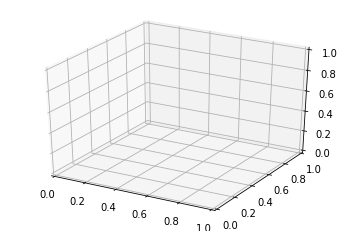

In [95]:
vCallV = np.vectorize(callV)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ts = np.linspace(1, 45.1, 5)
ss = np.linspace(70, 200, 5)
Ts, Ss = np.meshgrid(ts, 
                     ss)
#Ts = Ts.T
#Ss = Ss.T
print("ts,\n", ts)
print("ss,\n", ss)
Cs = vCallV(S = Ss, t = Ts, E1 = 80, E2 = 201, r = 0.03, sig = 0.09, T = 100)
print("Cs,\n", Cs)

#ax.plot_surface(Ss, Ts, Cs)
ax.plot(ts, ss, zs = Cs)#np.asarray([[1, 2, 3]], [[4, 3, 2]], [[2, 3, 4]])
plt.show()